# **FINGERPRINT IDENTIFICATION WITH DEEP LEARNING**

Ứng dụng mạng học sâu vào mô hình xác thực dấu vân tay

Nội dung của `notebook` này là nói về chúng ta sẽ cài đặt và huấn luyện sao cho mô hình có thể phân biệt được 2 dấu vân tay có khớp nhau hay không. 

Nếu khớp nhau thì kết quả thông báo `True`, ngược lại sẽ là `False`.

In [1]:
# Khai báo các thư viện cơ bản
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

Nếu `run all` trên `local host` thì ta sẽ dùng `cell` bên dưới

In [2]:
TYPE_MODEL = 'base'
ROOT_DB = '..'
SAVE_MODEL_DIR = './model/'

Nếu `run all` trên `google colab` thì ta sẽ dùng `cell` bên dưới

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')
# try:
#   os.listdir('/content/SOCOFing-npz')
# except:
#   !unzip '/content/drive/MyDrive/SyncPC/Biometric/SOCOFing-npz.zip'

# TYPE_MODEL = 'base'
# ROOT_DB = '/content/'

### 1. DATASET - `SOCOFing-npz`

Load dataset

In [4]:
x_real = np.load(f'{ROOT_DB}/SOCOFing-npz/x_real.npz')['data']
y_real = np.load(f'{ROOT_DB}/SOCOFing-npz/y_real.npy')

x_easy = np.load(f'{ROOT_DB}/SOCOFing-npz/x_easy.npz')['data']
y_easy = np.load(f'{ROOT_DB}/SOCOFing-npz/y_easy.npy')

x_medium = np.load(f'{ROOT_DB}/SOCOFing-npz/x_medium.npz')['data']
y_medium = np.load(f'{ROOT_DB}/SOCOFing-npz/y_medium.npy')

x_hard = np.load(f'{ROOT_DB}/SOCOFing-npz/x_hard.npz')['data']
y_hard = np.load(f'{ROOT_DB}/SOCOFing-npz/y_hard.npy')

In [5]:
## In ra file csv để kiểm tra dữ liệu label có ý nghĩa là gì
# import pandas as pd
# pd.DataFrame(y_real).sort_values(by= [0, 2, 3]).to_csv('./y_real.csv', index = False)
# pd.DataFrame(y_easy).sort_values(by= [0, 2, 3]).to_csv('./y_easy.csv',  index = False)
# pd.DataFrame(y_medium).sort_values(by= [0, 2, 3]).to_csv('./y_medium.csv',  index = False)
# pd.DataFrame(y_hard).sort_values(by= [0, 2, 3]).to_csv('./y_hard.csv',  index = False)

Kiểm tra kích thước của dataset

In [6]:
print("Shapes:\t\t\t\t\t  Feature shape\t\t Label shape")
print("-----------------------------------------------------------------------------")
print(f"Finger Real data:\t\t\t{x_real.shape}\t  {y_real.shape}")
print(f"Finger Altered Easy data:\t\t{x_easy.shape}\t  {y_easy.shape}")
print(f"Finger Altered Medium data:\t\t{x_medium.shape}\t  {y_medium.shape}")
print(f"Finger Altered Hard data:\t\t{x_hard.shape}\t  {y_hard.shape}")

Shapes:					  Feature shape		 Label shape
-----------------------------------------------------------------------------
Finger Real data:			(6000, 90, 90, 1)	  (6000, 4)
Finger Altered Easy data:		(17931, 90, 90, 1)	  (17931, 4)
Finger Altered Medium data:		(17067, 90, 90, 1)	  (17067, 4)
Finger Altered Hard data:		(14272, 90, 90, 1)	  (14272, 4)


Phát hoạ một vài dấu vân tay trong dataset

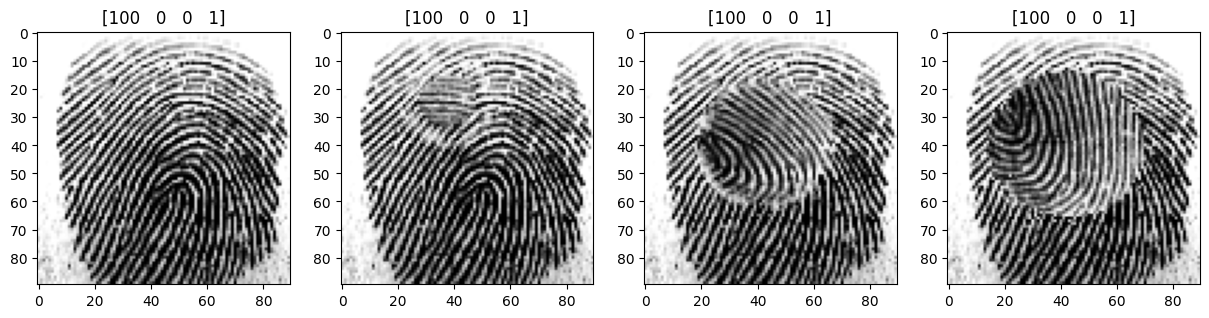

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

### 2. SPLIT AND CREATE DATAGENERATION

#### 2.1. Split dataset

In [8]:
from sklearn.model_selection import train_test_split

Chia bộ dữ liệu thành 3 tập [`train`, `validation`, `test`] với kích thước lần lượt là [`0.7`, `0.2`, `0.1`]

In [9]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

# Split dataset to train/val/test ~ 0.7/0.2/0.1
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.2) 
x_train, x_test, label_train, label_test = train_test_split(x_data, label_data, test_size=0.125)

Kiểm tra dữ liệu sau khi được chia

In [10]:
print("Shapes:\t\t\t\t\t  Feature shape\t\t Label shape")
print("-----------------------------------------------------------------------------")
print(f"Finger Full data:\t\t\t{x_data.shape}\t  {label_data.shape}")
print(f"Finger Train data:\t\t\t{x_train.shape}\t  {label_train.shape}")
print(f"Finger Valid data:\t\t\t{x_val.shape}\t  {label_val.shape}")
print(f"Finger Test data:\t\t\t{x_test.shape}\t  {label_test.shape}")
print(f"Finger Real data:\t\t\t{x_real.shape}\t  {y_real.shape}")

Shapes:					  Feature shape		 Label shape
-----------------------------------------------------------------------------
Finger Full data:			(49270, 90, 90, 1)	  (49270, 4)
Finger Train data:			(43111, 90, 90, 1)	  (43111, 4)
Finger Valid data:			(9854, 90, 90, 1)	  (9854, 4)
Finger Test data:			(6159, 90, 90, 1)	  (6159, 4)
Finger Real data:			(6000, 90, 90, 1)	  (6000, 4)


In [11]:
from imgaug import augmenters as iaa

#### 2.2. Augmentation dataset

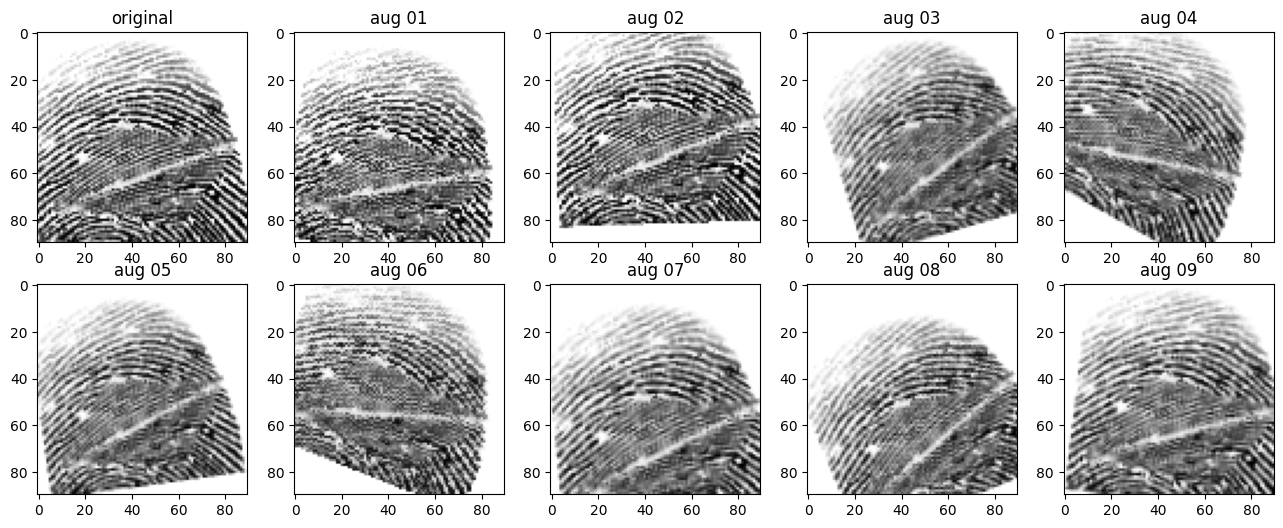

In [12]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

Tạo một label_real_dict là ...

In [13]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

Tạo DataGenerator từ `x`, `label` và `x_real`, `label_real_dict`.

In [14]:
import keras
from sklearn.utils import shuffle

In [15]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [16]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)
del x_train, label_train, x_val, label_val, x_data, label_data

### 3. FINGERPRINT IDENTIFICATION MODEL

In [17]:
from keras import layers, callbacks
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Model

#### 3.1. Model structure

Kiến trúc của model sẽ gồm 2 input đầu vào là 2 ảnh vân tay, cách thiết lập lần lược theo các bước:

- `Bước 1:` Hai ảnh sẽ được rút trích đặt trưng lần lược giống nhau. `(Conv -> MaxPooling -> Conv -> MaxPooling)`

- `Bước 2:` Sau đó, tại lớp `MaxPooling` thứ 2, ta sẽ `subtract` các lớp `Convolution` ở 2 ảnh này lại và ta sẽ có 1 lớp `Conv` duy nhất.

- `Bước 3:` Từ lớp `Conv` ở bước 2, ta tiếp tục `Conv` và `MaxPooling` các lớp ảnh.

- `Bước 4:` Ta sẽ duỗi thẳng các lớp ảnh ra và qua các lớp `Dense`, ta sẽ lọc ảnh về giá trị `Sigmoid` `[0, 1]`.

Kết quả trả về càng lớn thì độ trùng khớp của 2 dấu vân tay càng cao.

<p align="center">
    <img src = "./img/model_structure.png" alt = "drawing" width = "800"/>
</p>

In [18]:
class FINGER_MODELS():
    def __init__(self) -> None:
        self.shape = (90, 90, 1)
        pass
    
    def upgrade_model(self):
        pass

    def base_model(self):
        x1 = layers.Input(shape=self.shape)
        x2 = layers.Input(shape=self.shape)

        # share weights both inputs
        inputs = layers.Input(shape=self.shape)

        feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
        feature = layers.MaxPooling2D(pool_size=2)(feature)

        feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
        feature = layers.MaxPooling2D(pool_size=2)(feature)

        feature_model = Model(inputs=inputs, outputs=feature)

        # 2 feature models that sharing weights
        x1_net = feature_model(x1)
        x2_net = feature_model(x2)

        # subtract features
        net = layers.Subtract()([x1_net, x2_net])

        net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
        net = layers.MaxPooling2D(pool_size=2)(net)

        net = layers.Flatten()(net)

        net = layers.Dense(64, activation='relu')(net)

        net = layers.Dense(1, activation='sigmoid')(net)    

        model = Model(inputs=[x1, x2], outputs=net)

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

        return model
    
    def model(self, type_model = 'base'):
        if type_model == 'base':
            return self.base_model()
        else:
            return self.upgrade_model()

In [19]:
model = FINGER_MODELS().model(TYPE_MODEL)

Kiểm tra kiến trúc của model, input và output có đúng với dự tính hay không

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 22, 22, 32)   9568        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 22, 22, 32)   0           ['model[0][0]',            

In [21]:
x

NameError: name 'x' is not defined

#### 3.2. Train model

Ta sẽ huấn luyện mô hình dựa trên `val_loss`.

Các giá trị callbacks sẽ là: 
- ModelCheckpoint: Lưu mô hình có kết quả tốt nhất.
- EarlyStopping: Dừng huấn luyện khi `val_loss` không giảm sau `3` lần.

In [ ]:
monitor = 'val_accuracy'
epochs = 15

In [ ]:
checkPoint = callbacks.ModelCheckpoint( f'{SAVE_MODEL_DIR}/fingId-best-model.h5',
                                        save_best_only= True,
                                        save_weights_only= True,
                                        monitor = monitor,
                                        verbose = 3,
                                        mode = 'max')

earlyStop = callbacks.EarlyStopping(monitor = monitor,
                                    mode = 'max',
                                    patience = 3)

In [ ]:
history = model.fit_generator(train_gen, epochs=epochs, validation_data=val_gen, callbacks = [checkPoint, earlyStop])

Epoch 1/15
 589/1347 [============>.................] - ETA: 2:08 - loss: 0.3180 - acc: 0.8501

KeyboardInterrupt: 

Bởi vì ta đã có `ModelCheckpoint` để lưu mô hình tốt nhất, do đó, ta sẽ chỉ cần lưu mô hình ở cuối quá trình huấn luyện

In [ ]:
model.save_weights(f'{SAVE_MODEL_DIR}/fingId-last-model.h5')

#### 3.3. Evaluation

##### 3.3.1. Validation

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

model_name = f'{TYPE_MODEL}_model'

epochs = range(1, len(acc) + 1)
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# plot figures models
# ax[0][0].figure()
ax[0][0].plot(epochs, acc, label='Training acc of '+ model_name)
ax[0][0].plot(epochs, val_acc, label='Validation acc of '+ model_name)
ax[0][0].set_title('Training and validation accuracy of '+ model_name)
ax[0][0].legend()

# ax[1][0].figure()
ax[1][0].plot(epochs, loss,  label='Training loss of '+ model_name)
ax[1][0].plot(epochs, val_loss, label='Validation loss of '+ model_name)
ax[1][0].set_title('Training and validation loss of '+ model_name)
ax[1][0].legend()

##### 3.3.2. Test

Bởi vì `DataGenerator` không lưu vết `y_true`, nên sẽ rất khó cho chúng ta để tính `accuracy_score` và `confusion_matrix`.

Do đó, ta sẽ phải tạo lại `test_dataset` và ta sẽ tính `accuracy` dựa trên `predict` của từng phần tử trong `test_dataset`.

In [ ]:
def create_testSet(x_test, label_test):
    x = []
    y = []
    for idx in range(len(x_test)):
        img = x_test[idx]
        label = label_test[idx]

        seq = iaa.Sequential([
            iaa.GaussianBlur(sigma=(0, 0.5)),
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-30, 30),
                order=[0, 1],
                cval=255
            )
        ], random_order=True)

        img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

        # matched image
        match_key = label.astype(str)
        match_key = ''.join(match_key).zfill(6)

        rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        ry = y_real[label_real_dict[match_key]]

        x.append([img, rx])
        y.append(1)

        # unmatched image
        while True:
          unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

          if unmatch_key != match_key:
              break
      
        ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
        uy = y_real[unmatch_idx]
        x.append([ux, rx])
        y.append(0)
    return x, y

In [ ]:
x, y = create_testSet(x_test, label_test)

Kiểm tra kích thước của tập test

In [ ]:
print(f'Kích thước của tập test là: {np.shape(x)}')

[array([167,   0,   1,   4], dtype=uint16),
 array([167,   0,   1,   4], dtype=uint16),
 array([233,   0,   0,   1], dtype=uint16),
 array([233,   0,   0,   1], dtype=uint16),
 array([567,   0,   1,   0], dtype=uint16),
 array([567,   0,   1,   0], dtype=uint16),
 array([480,   0,   1,   0], dtype=uint16),
 array([480,   0,   1,   0], dtype=uint16),
 array([347,   0,   0,   0], dtype=uint16),
 array([347,   0,   0,   0], dtype=uint16),
 array([192,   0,   0,   3], dtype=uint16),
 array([192,   0,   0,   3], dtype=uint16),
 array([351,   0,   1,   0], dtype=uint16),
 array([351,   0,   1,   0], dtype=uint16),
 array([74,  1,  0,  0], dtype=uint16),
 array([74,  1,  0,  0], dtype=uint16),
 array([598,   0,   1,   0], dtype=uint16),
 array([598,   0,   1,   0], dtype=uint16),
 array([139,   0,   1,   3], dtype=uint16),
 array([139,   0,   1,   3], dtype=uint16),
 array([538,   0,   0,   2], dtype=uint16),
 array([538,   0,   0,   2], dtype=uint16),
 array([236,   0,   1,   1], dtype=uint1

In [ ]:
print(f'Kích thước nhãn ở tập test là: {np.shape(y)}')

Dự đoán (`predict`) từng phần tử trong tập `test`

In [ ]:
y_pred = []
for x_pred in x:
  y_pred.append(model.predict(x_pred))

Kết quả đạt được sau khi model dự đoán là:

In [ ]:
y_pred = list(map(lambda x: 0 if x < 0.95 else 1, y_pred))
y_pred = np.array(y_pred).reshape(-1)
y_pred

Nhãn chính xác của tập `test`

In [ ]:
y_true = np.array(y).reshape(-1)
y_true

Tính `accuracy_score` dựa trên kết quả dự đoán từ model

In [ ]:
print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')

##### 3.3. Visualize test image

In [ ]:
# new user fingerprint input
random_idx = random.randint(0, len(x_test))

random_img = x_test[random_idx]
random_label = label_test[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')